# Phân Loại Xác Suất (Probabilistic Classifier): Naive Bayes và KDE
*Đóng góp: Nguyễn Tuấn Khôi, The University of Melbourne, Australia*

In [1]:
import numpy as np 
import pandas as pd
from collections import defaultdict

## 0. Mô hình phân loại xác suất cơ bản

Chúng ta bắt đầu bằng 1 bài toán xác suất cơ bản: 

> Một ngày đẹp trời, bạn đi xem thầy bói. Thầy phán rằng bạn sẽ ế trước khi bạn 30. Bạn biết rằng trước đó có 10 người bạn già của bạn cũng đi xem ông này bói, và có 6 người ông ấy phán là sẽ ế. Trong 6 người đó, có 2 người sau này lại có người yêu trước 30, còn 4 người ông ấy phán không ế, có 1 ông tới năm 30 vẫn phải quẹt Tinder. Bạn thắc mắc rằng, khả năng mình ế thật sự sẽ là bao nhiêu phần trăm?

Trong các phương pháp để phân loại dữ liệu, sử dụng xác suất là một trong những phương pháp phổ biến nhất. Từ 1 tập dữ liệu có sẵn, ta có thể tính toán ra các xác suất của từng phân loại cho mỗi thực thể T. Và hiển nhiên, các mô hình này sẽ chọn phân loại khả thi nhất cho thực thể đó:

$$$
class(T) = argmax_{c_i}[P(c_i|T)]
$$$

> 'Tên gì? Nhà quận mấy? Có xe chưa?...'

Tất nhiên khi xem bói, thì ông thầy bói cũng hỏi bạn đủ thứ số mệnh rồi. Trong những trường hợp 1 thực thể T có nhiều đặc điểm x, thì mô hình sẽ tổng hợp xác suất cho mỗi đặc điểm, rồi cộng lại với nhau:

$$$
class(T) = argmax_{c_i}\Big[\sum_{x_j \in T} P(c_i|x_j)\Big]
$$$



In [2]:
test = defaultdict(str)
p_e_given_true = defaultdict(float)
p_e_given_false = defaultdict(float)
p_not_e_given_true = defaultdict(float)
p_not_e_given_false = defaultdict(float)
trait_list = []
non_trait_list = []

print("THẦY BÓI TÌNH DUYÊN 4.0")
# Nhập và phân tách dữ liệu
data = pd.read_csv('train.csv').select_dtypes(include = 'bool')
print("*"*80)
print(data)
print("*"*80)
true_data = data.loc[data['Ế']==True]
false_data = data.loc[data['Ế']==False]

# Tổng hợp lại từng xác suất trong từng trường hợp, đồng thời hỏi thông tin người xem bói
for c in data.columns[:-1]:
    test[c] = input("Bạn có " + c + " không? (Y/N)") in 'YESYesyes'
    true_col = true_data.loc[true_data[c]==True]
    false_col = false_data.loc[false_data[c]==True]
    p_e_given_true[c] = len(true_col)/len(true_data)
    p_e_given_false[c] = 1-p_e_given_true[c]
    p_not_e_given_true[c] = len(false_col)/len(false_data)
    p_not_e_given_false[c] = 1-p_not_e_given_true[c]

    print(f"P(Ế | {c:s} = True): {p_e_given_true[c]:.2f}\t\t\t P(Ế | {c:s} = False): {p_e_given_false[c]:.2f}")
    print(f"P(Không Ế | {c:s} = True): {p_not_e_given_true[c]:.2f}\t\t P(Không Ế | {c:s} = False): {p_not_e_given_false[c]:.2f}")

# Tổng các xác suất cho "ế" và "không ế"
e_total = sum([p_e_given_true[c] if test[c] else p_e_given_false[c] for c in data.columns[:-1]])
khong_e_total = len(data.columns[:-1])-e_total

print("\n P(Ế) = " + " + ".join([f"P(Ế | {c:s} = {str(test[c]):s})" for c in data.columns[:-1]]) + f" = {e_total:.2f}")
print(" P(Không Ế) = " + " + ".join([f"P(Không Ế | {c:s} = {str(not test[c]):s})" for c in data.columns[:-1]]) + f" = {khong_e_total:.2f}\n")

res = "ế chỏng chơ tới 30, đen thôi đỏ quên đi." if e_total > khong_e_total else "còn cơ hội trước 30. Quẩy lên."
print(f"Bạn {res:s}")


THẦY BÓI TÌNH DUYÊN 4.0
********************************************************************************
   đẹp trai  khoai to  học giỏi      Ế
0     False      True     False   True
1     False     False     False   True
2     False      True     False   True
3      True      True      True   True
4      True     False     False  False
5      True      True      True  False
6     False      True     False   True
7      True     False      True  False
8      True      True      True  False
9     False     False     False  False
********************************************************************************
P(Ế | đẹp trai = True): 0.20			 P(Ế | đẹp trai = False): 0.80
P(Không Ế | đẹp trai = True): 0.80		 P(Không Ế | đẹp trai = False): 0.20
P(Ế | khoai to = True): 0.80			 P(Ế | khoai to = False): 0.20
P(Không Ế | khoai to = True): 0.40		 P(Không Ế | khoai to = False): 0.60
P(Ế | học giỏi = True): 0.20			 P(Ế | học giỏi = False): 0.80
P(Không Ế | học giỏi = True): 0.60		 P(Không Ế | học 

Để có thể đủ dữ liệu để so sánh, với $c$ phân loại, $m$ đặc điểm, mỗi đặc điểm gồm $k$ loại, ta cần $O(ck^m)$ để có thể dự đoán cho mọi trường hợp. Nhưng thực tế, không làm mà đòi có ăn là không được, dữ liệu không phải lúc nào cũng có đầy đủ. Nếu như mỗi cá thể có tới trên 20 biến nhị phân, thì sẽ cần tối thiểu $c \times 2^{20} \approx c \times 10^6$ dữ liệu. Và vì vậy, cần có một phương pháp phù hợp hơn để phân loại, thay vì cứ gom lại.

## 1. Naive Bayes - Biến rời rạc
### 1.1 Mô hình
Cách đơn giản nhất để xử lí việc không có đủ dữ liệu trùng khớp để so sánh, đó là tìm ngược lại rằng liệu mỗi phân loại có thể có những đặc điểm trên hay không. Thay vì tìm một người như bạn rồi xem người đó có ế hay không, ông thầy sẽ tìm xem người ế thường giống bạn chỗ nào không. Nói một cách toán học, thì ta sẽ tìm $P(x_j|c_i)$ từ $P(c_i|x_j)$. Nguyên lí Bayes là công thức ta cần để đạt được việc này:

$$$
P(H|x)=\frac{P(x|H)P(H)}{P(x)}
$$$

Những gì ta cần là:
* $P(H|x)$ - Những đối tượng có đặc tính $x$ có bao nhiêu phần thuộc phân loại $H$?
* $P(H)$ - Phân loại $H$ chiếm bao nhiêu phần trong tập thể?
* $P(x)$ - Đặc điểm $x$ chiếm bao nhiêu phần trong tập thể?

Bằng công thức này, ta sẽ chọn phân loại có nhiều đặc tính trùng khớp với đối tượng nhất:

$$$
class(T) = argmax_{c_i}\Big[\frac{P(T|c_i)P(c_i)}{P(T)}\Big]
$$$

Với nhiều đặc điểm, nguyên lí Bayes sẽ giả định rằng những đặc điểm này độc lập lẫn nhau cho dễ tính, và điều này tạo nên cái tên "Naive" (nai tơ). Như vậy, ta có thể sử dụng công thức tính xác suất của các đặc điểm độc lập:

$$$
P(x_1,x_2,...,x_n|c) = \prod_{x_i \in T} P(x_i|c)
$$$

Bằng cách thay thực thể $T$ bằng 1 dãy đặc điểm $[x_1,x_2,...,x_n]$, công thức sẽ trở thành:

$$$
class(T) = argmax_{c_i}\Big[\frac{P(c_i)\prod_{x_i \in T} P(x_i|c)}{P(T)}\Big]
$$$

Khoan, dừng lại khoảng chừng là 20 giây! Có thể rút gọn phần nào phương trình này không?

Chúng ta có thể để ý rằng dù cho phân loại có là gì, thì xác suất tìm được các đặc tính trong một tập thể $P(T)$ vẫn giữ nguyên và không làm ảnh hưởng đến trật tự của các kết quả. Và vì vậy, con số này không nhất thiết phải mang vào công thức, vì mục đích cuối cùng của mô hình vẫn là so sánh để tìm ra xác suất lớn nhất mà thôi:

$$$
class(T) = argmax_{c_i}\Big[P(c_i)\prod_{x_i \in T} P(x_i|c)\Big]
$$$

In [3]:
from sklearn.naive_bayes import CategoricalNB

input_info = []

print("THẦY BÓI TÌNH DUYÊN 4.0.1")
data = pd.read_csv('train.csv').select_dtypes(include = 'bool')
print("*"*80)
print(data)
print("*"*80)
for c in data.columns[:-1]:
    input_info.append(input("Bạn có " + c + " không? (Y/N)") in 'YESYesyes')

x = data.iloc[:,:-1]
y = data.iloc[:,-1]

clf = CategoricalNB(alpha = 0.5) # Laplace Smoothing, xem 1.2.3
clf.fit(x, y)

out = clf.predict([input_info])
res = "ế chỏng chơ tới 30, đen thôi đỏ quên đi." if out[0] else "còn cơ hội trước 30. Quẩy lên."
print(f"Bạn {res:s}")

THẦY BÓI TÌNH DUYÊN 4.0.1
********************************************************************************
   đẹp trai  khoai to  học giỏi      Ế
0     False      True     False   True
1     False     False     False   True
2     False      True     False   True
3      True      True      True   True
4      True     False     False  False
5      True      True      True  False
6     False      True     False   True
7      True     False      True  False
8      True      True      True  False
9     False     False     False  False
********************************************************************************
Bạn còn cơ hội trước 30. Quẩy lên.


Bằng cách tổng hợp các xác suất từ dữ liệu có sẵn, ta có thể thấy mô hình Naive Bayes là một mô hình supervised đưa ra dự đoán từ thông tin có sẵn, giả định sự độc lập của các đặc điểm để tính toán thuận tiện hơn. Tuy nhiên ngoài thực tế, hầu hết các đặc điểm đều không độc lập hoàn toàn khỏi các đặc điểm khác, và vì thế mô hình này không hoàn toàn chính xác. Dù vậy, Naive Bayes vẫn trở nên hiệu quả trong hầu hết các trường hợp, và là một trong các mô hình phân loại phổ biến trong Machine Learning. Thực tế thì ông thầy bói mà nói toẹt ra rằng việc bạn thế này không ảnh hưởng tới việc bạn thế kia thì còn ai mà đi xem bói nữa đâu hehe.

### 1.2 Tie breaking

> Nếu bạn muốn bói tình duyên cho con Vitamin Gâu Gâu nhà bạn, liệu ông thầy bói có dự đoán được không?

Khi dự đoán, nếu một đặc điểm không thể xảy ra trong 1 phân loại, thì hiển nhiên xác suất cá thể đó thuộc phân loại kể trên là 0. Chính tại đây, khuyết điểm của mô hình Naive Bayes xuất hiện khi 1 cá thể có những đặc tính hiếm gần như chưa được thấy bao giờ, và vì vậy trở nên bất khả thi cho hầu hết mọi trường hợp. Và vì vậy, cần một phương pháp hợp lí để phân định rõ ràng những cá thể trên.

#### 1.2.1 Phân loại ngẫu nhiên
Đúng như tên gọi, phương pháp này là "vạn sự tùy duyên".

#### 1.2.2 Thay biến epsilon
Thay vì nói rằng xác suất bằng 0 là *bất khả thi* cho 1 phân loại $c$, có thể thay đổi cách nói thành *ca này khó*. Thay vì đưa 0 vào tích các xác suất, ta có thể đưa vào 1 con số $\epsilon < \frac{1}{count(c_i)}$. Như vậy, ta sẽ có 1 loạt ca khó, nhưng khi mà ca nào cũng khó, cái ít khó nhất hiển nhiên trở thành điều khả thi nhất.

#### 1.2.3 Laplace Smoothing - Tịnh tiến Laplace
Một cách khác để thay *bất khả thi* thành *ca này khó* là đếm dư thêm 1 (hoặc 1 số $\alpha \in [0,1]$) trường hợp cho mỗi đặc điểm $x_i$:

$$$
P_i = \frac{x_i}{N} \text{(Nguyên bản)} = \frac{x_i + \alpha}{N + \alpha d} \text{(Đã tịnh tiến, d = Số thực thể)}
$$$

## 2. Naive Bayes - Biến liên tục

> 'Tuổi? Cao bao nhiêu? BMI?...'

Sẽ dễ dàng biết mấy nếu ông thầy bói chỉ hỏi những câu hỏi mà bạn chỉ việc trả lời có hoặc không. Nhưng nếu như bạn phải trả lời bằng một con số (ví dụ như tuổi, chiều cao, ...) thì sao? Phương pháp Naive Bayes kể trên sử dụng tốt cho những biến rời rạc, nhưng khi những đặc điểm không chỉ là phân loại, mà là các con số đo đạc, cần phải có những cải biến cho mô hình để có thể áp dụng biến liên tục vào dự đoán.

### 2.1 Phân tách

Có thể phân dữ liệu của 1 biến liên tục thành các phần khác nhau, và phân loại cho từng phần thành 1 nhóm chung. 

#### 2.1.1 Phân tách theo khoảng (Uniform Discretization)
> 'Ngày sinh $\rightarrow$ Cung hoàng đạo'

Tìm khoảng giá trị của các dữ liệu, và chia đều thành $n$ khoảng nhỏ. Dữ liệu nằm trong cùng 1 khoảng giá trị đã chia sẽ được gộp thành 1 nhóm. 

#### 2.2.2 Phân tách theo số lượng (Quantile Discretization)
> 'MMR $\rightarrow$ Rank LoL (Top %)'

Sắp xếp thứ tự lại cho dữ liệu từ thấp đến cao hoặc ngược lại. Lấy $n$ dữ liệu đầu tiên gộp thành một nhóm, và cứ thế lặp lại cho mỗi $n$ (hoặc 1 số lượng khác tùy ý) dữ liệu tiếp theo.

#### 2.2.3 Các phương pháp clustering khác
> 'Địa chỉ $\rightarrow$ Nhà nghỉ gần nhất'

*Xem thêm: K-Means Clustering và KNN (Chương 4)*

In [4]:
from sklearn.preprocessing import KBinsDiscretizer
data = pd.read_csv('train.csv').iloc[:,-2:]
X = data.iloc[:,:-1]

unif = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
kmeans = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')
quant = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

u = unif.fit_transform(X)
data["Uniform"]=u

q = quant.fit_transform(X)
data["Quantile"]=q

k = kmeans.fit_transform(X)
data["K-Means"]=k

data.drop(data.columns[1],axis=1)

,lương tháng,Uniform,Quantile,K-Means
0,30000000.0,1.0,4.0,0.0
1,7000000.0,0.0,2.0,0.0
2,15000000.0,0.0,3.0,0.0
3,3000000.0,0.0,0.0,0.0
4,5000000.0,0.0,1.0,0.0
5,12000000.0,0.0,2.0,0.0
6,5500000.0,0.0,1.0,0.0
7,25000000.0,1.0,3.0,0.0
8,4000000.0,0.0,0.0,0.0
9,100000000.0,4.0,4.0,1.0


Việc phân tách có thể hiệu quả trong việc giản lược số liệu, nhưng đồng thời cũng sẽ làm giảm đi lượng thông tin có được. Một trong các cách để có thể giữ được lại nhiều thông tin nhất, đó là sử dụng phân phối để tính ra xác suất.

### 2.2 Gaussian Naive Bayes
Gaussian Naive Bayes vận hành như mô hình Naive Bayes thuần túy, nhưng lấy xác suất từ công thức phân phối Gaussian (phân phối chuẩn):

$$$
P(x_i|c) = \frac{1}{\sigma \sqrt{2\pi}}e^{-0.5\displaystyle \big(\frac{x_i-\mu}{\sigma}\big)^2} \\

x_i \in N(\mu,\sigma),
\;\;\;\;\;
\mu = \sum_{x_i} \frac{x_i}{N},
\;\;\;\;\;
\sigma = \sqrt{\frac{\sum^N_{i=1} (x_i-\mu)^2}{N-1}}
$$$

Và ta có thể thấy hiển nhiên rằng mô hình này giả định rằng dữ liệu được phân bố chuẩn. Điều này đúng trong hầu hết các trường hợp, khi mà phân phối chuẩn có thể dùng để ước lượng thay cho phần lớn các phân phối khác như nhị thức, Possion, Chi-square,...

In [9]:
from sklearn.naive_bayes import GaussianNB

print("THẦY BÓI TÌNH DUYÊN 4.0.2")
salary = int(input("Nhập lương tháng của bạn (VNĐ): "))

data = pd.read_csv('train.csv').iloc[:,-2:]
print("*"*40)
print(data)
print("*"*40)
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

clf = GaussianNB()
clf.fit(X,y)
out = clf.predict([[salary]])
res = "ế chỏng chơ tới 30, đen thôi đỏ quên đi." if out[0] else "còn cơ hội trước 30. Quẩy lên."
print(f"Bạn {res:s}")

THẦY BÓI TÌNH DUYÊN 4.0.2
****************************************
   lương tháng      Ế
0   30000000.0   True
1    7000000.0   True
2   15000000.0   True
3    3000000.0   True
4    5000000.0  False
5   12000000.0  False
6    5500000.0   True
7   25000000.0  False
8    4000000.0  False
9  100000000.0  False
****************************************
Bạn ế chỏng chơ tới 30, đen thôi đỏ quên đi.


### 2.3 Kernel Density Estimation

Tuy Gaussian Naive Bayes có thể sử dụng rộng rãi, dữ liệu ngoài thực tế thường có sự chênh lệch, và vì vậy không đảm bảo tính chính xác cao.


C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


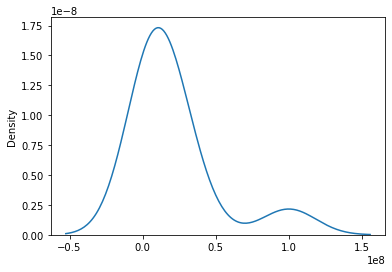

In [30]:
# Kiếm tra phân phối của dữ liệu lương tháng
import seaborn as sns
data = pd.read_csv('train.csv').iloc[:,-2:]
X = data.iloc[:,:-1]
sns.distplot(X,hist=False,kde=True)

Một cách khắc phục vấn đề này, đó là ước lượng một phân phối cụ thể và chính xác hơn cho các đặc điểm. Kernel Density Estimation (KDE) là một phương pháp tính phân phối hiệu quả trong trường hợp này, bằng cách tổng họp các phân phối chuẩn có cùng độ lệch chuẩn lại để ước lượng phân phối theo độ dày đặc:

$$$
P(x_i|c) = \frac{1}{N}\sum^N_{i=1}\phi_\sigma(x-x_i)\\~\\

\phi_\sigma = N(0,\sigma) \;\;\; (\sigma \text{ tự chọn})
$$$

Phương pháp này tuy hiệu quả hơn Gaussian Naive Bayes, nhưng sẽ cần chọn kernal bandwidth - độ lệch chuẩn cho các phân phối $\sigma$ hợp lí, cũng như chịu thêm thời gian tính toán khi phải tính phân phối chuẩn cho mỗi dữ liệu.


In [10]:
from sklearn.neighbors import KernelDensity
print("THẦY BÓI TÌNH DUYÊN 4.0.3")
salary = int(input("Nhập lương tháng của bạn (VNĐ): "))

data = pd.read_csv('train.csv').iloc[:,-2:]
print("*"*40)
print(data)
print("*"*40)
true_data = data.loc[data['Ế']==True]
false_data = data.loc[data['Ế']==False]
Xtrue = true_data.iloc[:,:-1]
Xfalse = false_data.iloc[:,:-1]

kde = KernelDensity(bandwidth=1)

kde.fit(Xtrue)
outTrue = kde.score([[salary]])/len(true_data)

kde.fit(Xfalse)
outFalse = kde.score([[salary]])/len(false_data)

res = "ế chỏng chơ tới 30, đen thôi đỏ quên đi." if outTrue > outFalse else "còn cơ hội trước 30. Quẩy lên."
print(f"Bạn {res:s}")

THẦY BÓI TÌNH DUYÊN 4.0.3
****************************************
   lương tháng      Ế
0   30000000.0   True
1    7000000.0   True
2   15000000.0   True
3    3000000.0   True
4    5000000.0  False
5   12000000.0  False
6    5500000.0   True
7   25000000.0  False
8    4000000.0  False
9  100000000.0  False
****************************************
Bạn còn cơ hội trước 30. Quẩy lên.


## 3. Kết bài
Naive Bayes, cũng như các phương pháp phân loại bằng xác suất khác trở nên thuận tiện khi ta biết được những dữ liệu trước đó, qua các bước tính toán không mang tính phức tạp cao. Trong hầu hết các trường hợp, các phương pháp xử lí phù hợp sẽ được sử dụng cho từng loại dữ liệu khác nhau:

* Phân định cho các xác suất 0: lựa chọn ngẫu nhiên, thay số $\epsilon$, tịnh tiến Laplace.
* Phân tách biến liên tục thành biến rời rạc: Uniform (khoảng), Quantile (Số lượng), các phương pháp clustering (K-Means, KNN),...
* Áp dụng biến liên tục trong mô hình: Gaussian Naive Bayes (phân phối chuẩn, tính toán nhanh), Kernel Density Estimation (tất cả các loại phân phối, tính toán trung bình chậm)

Tuy sự giả định về tính độc lập của các yếu tố sẽ làm giảm độ chính xác của mô hình, Naive Bayes vẫn giữ vai trò nhất định trong việc phân loại dữ liệu, và là một trong những thuật toán dự đoán phổ biến nhất của Machine Learning. 

Khi đọc xong bài hướng dẫn này, bạn đã có thể tự làm thầy bói 4.0 cho mình rồi đấy, hay thậm chí mở hàng bói cho người khác luôn. Kèo thơm thì mua tác giả cốc cà phê cám ơn là được rồi, còn kèo khắm thì tác giả xin miễn trừ trách nhiệm nhé hehehe.

Tham khảo và đọc thêm:
* Multinomial Naive Bayes, Bernoulli Naive Bayes
* Xác suất (ch.3)
* Bayes Inference (ch.4)
* Gaussian & Bayes Gaussian Mixture Model (ch.4)

## 4. Bài tập
1. Sử dụng nguyên lí Bayes để giải bài toán xác suất nơi ta bắt đầu.
2. Xây dưng mô hình tiên đoán với tất cả các cột trong file `train.csv` bằng phương pháp phân tách các biến liên tục.
3. Cho 2 mô hình Naive Bayes A và B. Nếu A chỉ có thể tiên đoán dữ liệu rời rạc, còn B chỉ có thể tiên đoán dữ liệu liên tục, thì liệu chỉ dùng A và B, có thể tiên đoán tất cả các cột trong file `train.csv` khi không sử dụng phân tách hay viết lại mô hình không? Giải thích.